<h1 align="center">
    <img 
        src="./img/Microsoft-Logo.png" 
        width="400"/>
</h1>
<h1 align="center">
    <b>Practical Guide</b>
</h1>
<h4 align="center">
    for the creation of an AI Solution using an accelerator from the <a href="https://www.ds-toolkit.com/">Data Science Toolkit</a>
</h4>

# What to expect

* **Challenge 1:** *Automatically determine relevant features from the set of questions.*
* **Challenge 2:** *From the dataset, fill out the dataset of the new features defined.*
* **Challenge 3:** *Fit and evaluate regression models using the features of the previous step as inputs and the metrics evaluated as outputs. Then apply SHAP to the newly created models.*

# Challenge 1: *Determine relevant features from the questions*

Here we will use the set of questions and leverage an LLM to determine what would be good features to try and understand the resulting metrics.

## Challenge 1 - Step 1:  Let's import the required packages and libraries.

>This is going to be done in a quiet mode, and only errors will be displayed if they occur. If you like to see what is going to be installed look at the [requirements.txt](./requirements.txt) file.

In summary two main tools will be installed that will be used in this notebook:

* **genAISHAP**. Is the library containing the tools for the DS Toolkit.
* **shap**. A popular library used to help with interpretability.

In [11]:
%%time
import pandas as pd
from genaishap import Featurizer, GenAIExplainer
import matplotlib.pyplot as plt
import shap
from IPython.display import Markdown, display, clear_output

import ipywidgets as widgets
from IPython.display import display

LOAD_PRECALCULATED_VALUES = True

shap.initjs()

CPU times: total: 0 ns
Wall time: 153 ms


### Some definitions:

* **Context prescision:** Measures how much of the generated output is relevant and aligns with the context provided in the input.
* **Context recall:** Measures how much of the relevant information in the input context is included in the output.
* **Faithfulness:** Measures how accurate and truthful the generated output is in relation to the input context and factual correctness. Faithfulness is about avoiding "hallucinations" (made-up or false information).

Below, the dataset of questions, retrieved contexts, generated and expected responses and their corresponding metrics is presented. Remember that this dataset is generated following the same procedure explained in the previous notebook.

In [2]:
df_test_dataset = pd.read_json('./test-dataset.json', orient='records')
df_test_dataset.head(10)

,user_input,retrieved_contexts,response,reference,faithfulness,context_precision,context_recall
0,Can you provide for me the three highlights fo...,"[31. In 2018, to align with industry best prac...",The three highlights for the GHG emissions sec...,"Sure, they are: \n1. 65% cumulative GHG emissi...",1.000000,0.0,0.0
1,What percentage of waste from Google's offices...,[Performance highlights\nThe following section...,"In 2021, 78% of waste from Google's global dat...",Sixty-four percent.,1.000000,0.0,0.0
2,Can you present me with the performance highli...,"[Education\nFor more than 40 years, we’ve work...",The performance highlights for empowering user...,Sure! The Performance Highlights for Empowerin...,1.000000,0.0,0.0
3,What was the listed key achievement regarding ...,[Our approach\nWe believe that every business ...,There is no listed key achievement for Google ...,"In 2017, Google became the first major company...",1.000000,1.0,1.0
4,Did Google reach its intended Waste target und...,[BUILDING BETTER DEVICES AND SERVICES\nTarget ...,"Yes, in 2021, Google achieved the UL 2799 Zero...","No, this target has not been met in 2021. Howe...",0.666667,1.0,1.0
5,How many EV charging locations were there on G...,[This guidance does not recognize existing ren...,The provided context does not specify the numb...,200000,1.000000,0.0,0.0
6,On what page of the report can I find the perf...,"[Employee Recruitment, Inclusion and Performan...",The performance highlights for the Empowering ...,The performance highlights for Empowering User...,0.000000,0.0,0.0
7,Can you please provide for me the glossary of ...,[GRI INDEX\nGRI 304 - Biodiversity\nGRI 103 Ma...,I'm unable to provide the glossary of the docu...,"Sure, here is the glossary:\nGlossary\nCFE: ca...",0.500000,0.0,0.0
8,On what page can I find details about Amazons ...,[IntroductionSustainability\nDriving Climate S...,You can find details about Amazon's climate so...,You can find information on driving climate so...,0.000000,0.0,0.0
9,"For the listed Renewable Energy goals, by when...",[IntroductionSustainability\nDriving Climate S...,Amazon intends to have all operations powered ...,Amazon set the goal of becoming powered by 100...,1.000000,1.0,0.0


In [3]:
df_test_dataset.iloc[1,0]

"What percentage of waste from Google's offices globally were diverted away from landfills in 2021?"

## Challenge 1 - Step 2: Let's extract features from the questions in the dataset

* To do this, we will use the function `Featurizer` from the **genAISHAP** library.
* The features created are then displayed. Remember that these features are generated automatically.

**GenAISHAP** has a utility to automatically create features from the `user_input` entries. This tool, called **featurizer**, works by using an LLM to go through the existing questions in the dataset and extracts what would be relevant pieces of information that would be useful as features in a regression model.

In [4]:
%%time

# The Featurizer is part of the DS Toolkit and is able to take the list of provided questions and create a dataset of features for them automatically.
featurizer = Featurizer.from_pandas(df_test_dataset)
featurizer.create_features_using_azure_openai(
    deployment_name="gpt-4o", # Update with the name of your Azure OpenAI LLM deployment name
    num_features=25
)
print(featurizer.features.model_dump_json(indent=4))

{
    "features": [
        {
            "feature": "there_is_any_company_identified_in_the_question",
            "ftype": "boolean"
        },
        {
            "feature": "list_of_companies_identified_in_the_question",
            "ftype": "list_of_strings"
        },
        {
            "feature": "there_is_any_topic_or_section_identified_in_the_question",
            "ftype": "boolean"
        },
        {
            "feature": "list_of_topics_or_sections_identified_in_the_question",
            "ftype": "list_of_strings"
        },
        {
            "feature": "there_is_any_specific_year_identified_in_the_question",
            "ftype": "boolean"
        },
        {
            "feature": "list_of_years_identified_in_the_question",
            "ftype": "list_of_strings"
        },
        {
            "feature": "there_is_any_specific_page_number_identified_in_the_question",
            "ftype": "boolean"
        },
        {
            "feature": "list_of_page_num

# Challenge 2: From the dataset, fill out the dataset of the new features defined.

**GenAISHAP** also includes another utility to automatically fill out the values for each user input for each feature. Once more, we leverage an LLM to fill out each of the features for each of the questions. It works like answering questions about the question (e.g., if the feature is `is_Microsoft_mentioned`, it literally checks if Microsoft is mentioned in the question).

In [5]:
%%time

featurizer.fill_out_features_using_azure_openai(
    deployment_name="gpt-4o", 
    batch_size=5
)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 297 ms
Wall time: 59.2 s


In [12]:
if LOAD_PRECALCULATED_VALUES:
    df_features = pd.read_json('./test-features.json', orient='records')
else:
    df_features = featurizer.to_pandas()
    
df_test_dataset.join(df_features).head()

,user_input,retrieved_contexts,response,reference,faithfulness,context_precision,context_recall,there_is_any_company_identified_in_the_question,list_of_companies_identified_in_the_question,there_is_any_topic_or_section_identified_in_the_question,...,is_a_question_related_to_achievements_or_highlights,is_a_question_related_to_goals_or_targets,is_a_question_related_to_specific_initiatives,list_of_initiatives_identified_in_the_question,is_a_question_related_to_comparisons,is_a_question_related_to_quantitative_data,list_of_quantitative_data_identified_in_the_question,is_a_question_related_to_qualitative_data,list_of_qualitative_data_identified_in_the_question,is_a_question_related_to_testimonials_or_quotes
0,Can you provide for me the three highlights fo...,"[31. In 2018, to align with industry best prac...",The three highlights for the GHG emissions sec...,"Sure, they are: \n1. 65% cumulative GHG emissi...",1.000000,0.0,0.0,False,[],True,...,True,False,False,[],False,False,[],True,[highlights],False
1,What percentage of waste from Google's offices...,[Performance highlights\nThe following section...,"In 2021, 78% of waste from Google's global dat...",Sixty-four percent.,1.000000,0.0,0.0,True,[Google],True,...,True,False,False,[],False,True,[percentage of waste diverted],False,[],False
2,Can you present me with the performance highli...,"[Education\nFor more than 40 years, we’ve work...",The performance highlights for empowering user...,Sure! The Performance Highlights for Empowerin...,1.000000,0.0,0.0,False,[],True,...,True,False,False,[],False,False,[],True,[highlights],False
3,What was the listed key achievement regarding ...,[Our approach\nWe believe that every business ...,There is no listed key achievement for Google ...,"In 2017, Google became the first major company...",1.000000,1.0,1.0,True,[Google],True,...,True,False,False,[],False,False,[],True,[key achievement],False
4,Did Google reach its intended Waste target und...,[BUILDING BETTER DEVICES AND SERVICES\nTarget ...,"Yes, in 2021, Google achieved the UL 2799 Zero...","No, this target has not been met in 2021. Howe...",0.666667,1.0,1.0,True,[Google],True,...,True,True,True,[Building Better Devices and Services Initiative],False,False,[],True,[intended target],False


# Challenge 3: 
## Challenge 3 - Step 1: Fit and evaluate regression models using the features of the previous step as inputs and the metrics evaluated as outputs.

> **TO DO:** Explain what happens in the toolkit including:
> * Creation of multiple regression models for each metric. For these models, the input variables are the automatically generated features from the previous steps and the output variable is the variable in question. Multiple models are created and the best performing one is selected.
> * In order to do that, some variables are converted, e.g., using one-hot encoding. This means the the models will be working with more variables than the original defined number.

In [13]:
genai_explainer = GenAIExplainer.from_pandas(df_test_dataset, df_features)
genai_explainer.feature_engineering()
genai_explainer.create_explainers()

Metric loop:   0%|          | 0/3 [00:00<?, ?it/s]

faithfulness:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\vscode\src\repos\tc-2025\.venv\lib\site-packages\genaishap\explainer.py:298: UserWarning: There are 3 estimated values in the metric faithfulness far from the original values. The following is the list of indexes [25, 26, 27].
  warnings.warn(


context_precision:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\vscode\src\repos\tc-2025\.venv\lib\site-packages\genaishap\explainer.py:298: UserWarning: There are 3 estimated values in the metric context_precision far from the original values. The following is the list of indexes [25, 26, 27].
  warnings.warn(


context_recall:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\vscode\src\repos\tc-2025\.venv\lib\site-packages\genaishap\explainer.py:298: UserWarning: There are 3 estimated values in the metric context_recall far from the original values. The following is the list of indexes [25, 26, 27].
  warnings.warn(


### Show the `r2 score` of the selected models

In [14]:
genai_explainer.r2_scores_

{'faithfulness': 0.8924309799394129,
 'context_precision': 0.984284771295884,
 'context_recall': 0.9314803928239576}

### Let's select one of our metrics
1. Select on of the metrics from the dropdown menu below.
2. Check how well the regression model created with the automated features follows the selected metric. This should give us an idea about how reliable our explanations are.

Dropdown(description='Select:', index=2, options=('', 'faithfulness', 'context_precision', 'context_recall'), …


### **context_precision:** Measures how much of the generated output is relevant and aligns with the context provided in the input.


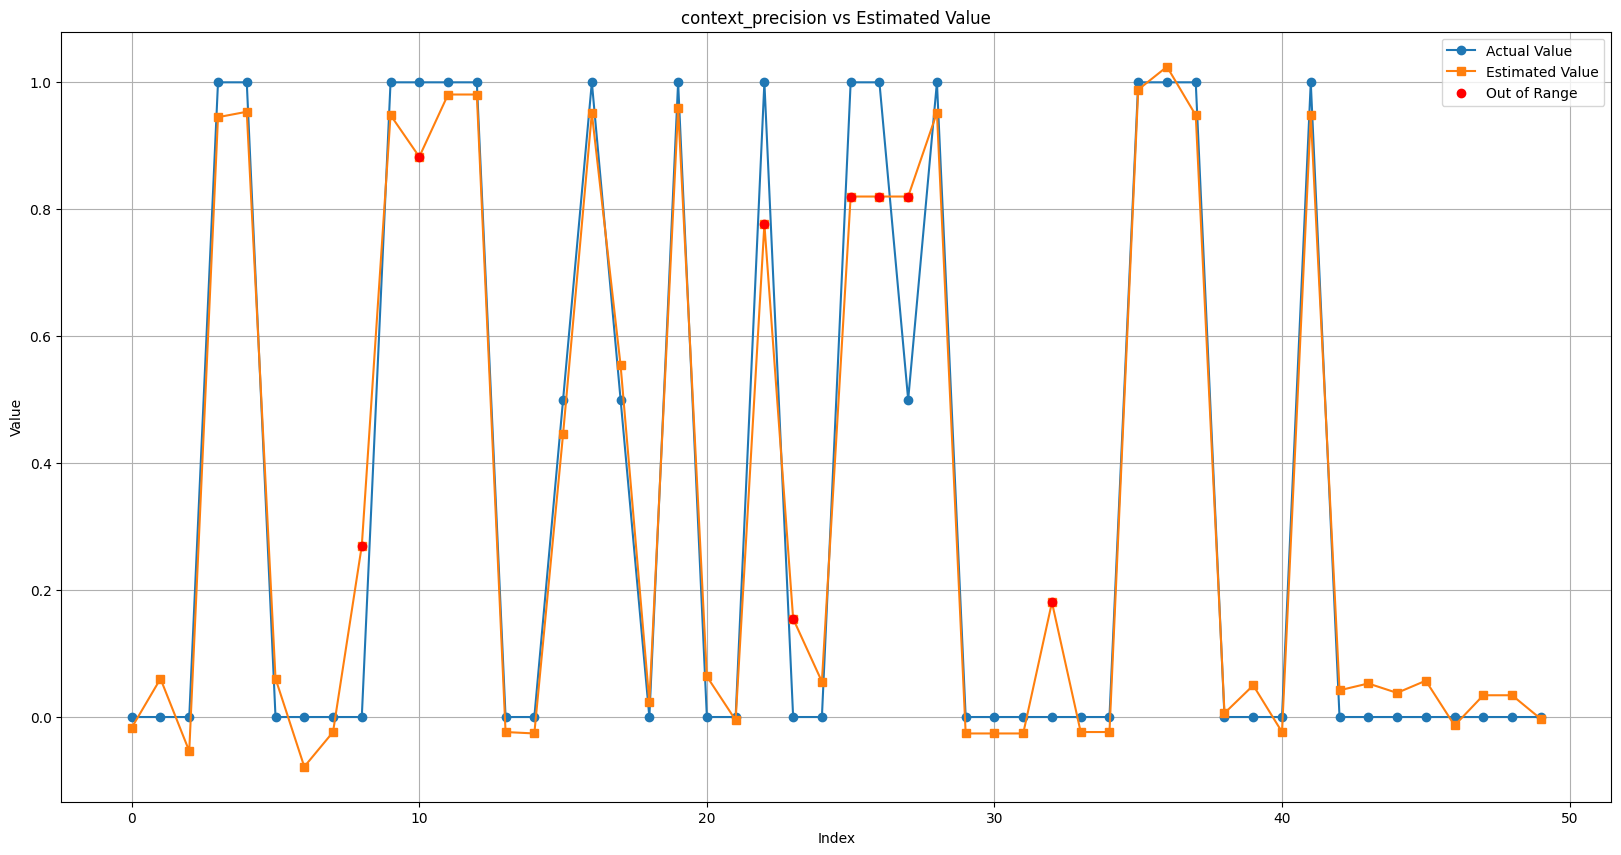

In [20]:
dropdown_values = ["", "faithfulness", "context_precision", "context_recall"]

# Create a dropdown widget
dropdown = widgets.Dropdown(
    options=dropdown_values,
    description='Select:',
    disabled=False,
)

# Function to handle the dropdown selection
def on_change(change):
    global sel_metric
    global metric
    global X
    global metric_text
    global df_metric
    sel_metric = change['new']
    # print(f'Selected metric: {sel_metric}')

    # Clear the previous output
    clear_output(wait=True)
    
    # Display the dropdown widget again
    display(dropdown)

    if sel_metric == "faithfulness":
        metric_text = "Measures how accurate and truthful the generated output is in relation to the input context and factual correctness. Faithfulness is about avoiding hallucinations (made-up or false information)"
    elif sel_metric == "context_precision":
        metric_text = "Measures how much of the generated output is relevant and aligns with the context provided in the input."
    elif sel_metric == "context_recall":
        metric_text = "Measures how much of the relevant information in the input context is included in the output."
    
    metric_details = f"""
### **{sel_metric}:** {metric_text}
"""
    # Display a reminder of the metric's definition
    display(Markdown(metric_details))

    # Plot the actual vs estimated values for the selected metric
    metric = sel_metric
    X = pd.DataFrame(genai_explainer.preprocessed_features)

    df_metric = pd.DataFrame(genai_explainer.metrics)[[metric]]
    df_metric['estimated_value'] = genai_explainer.estimators_[metric].predict(X)
    df_metric['is_out_of_range'] = genai_explainer.is_out_of_range_[metric]



    plt.figure(figsize=(20,10))
    plt.plot(df_metric[metric], label='Actual Value', marker='o')
    plt.plot(df_metric['estimated_value'], label='Estimated Value', marker='s')

    # Highlight the out-of-range values
    out_of_range_indices = df_metric[df_metric['is_out_of_range']].index
    plt.scatter(out_of_range_indices, df_metric.loc[out_of_range_indices, 'estimated_value'], color='red', label='Out of Range', zorder=5)

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'{metric} vs Estimated Value')
    plt.legend()
    plt.grid(True)
    plt.show()
# Attach the function to the dropdown widget
dropdown.observe(on_change, names='value')



display(dropdown)

## Challenge 3 - Step 2: Present the explainability results from SHAP
### For the selected metric show the SHAP values of each feature.

> **TO DO:** Provide a syntethized explanation of SHAP and the plot below

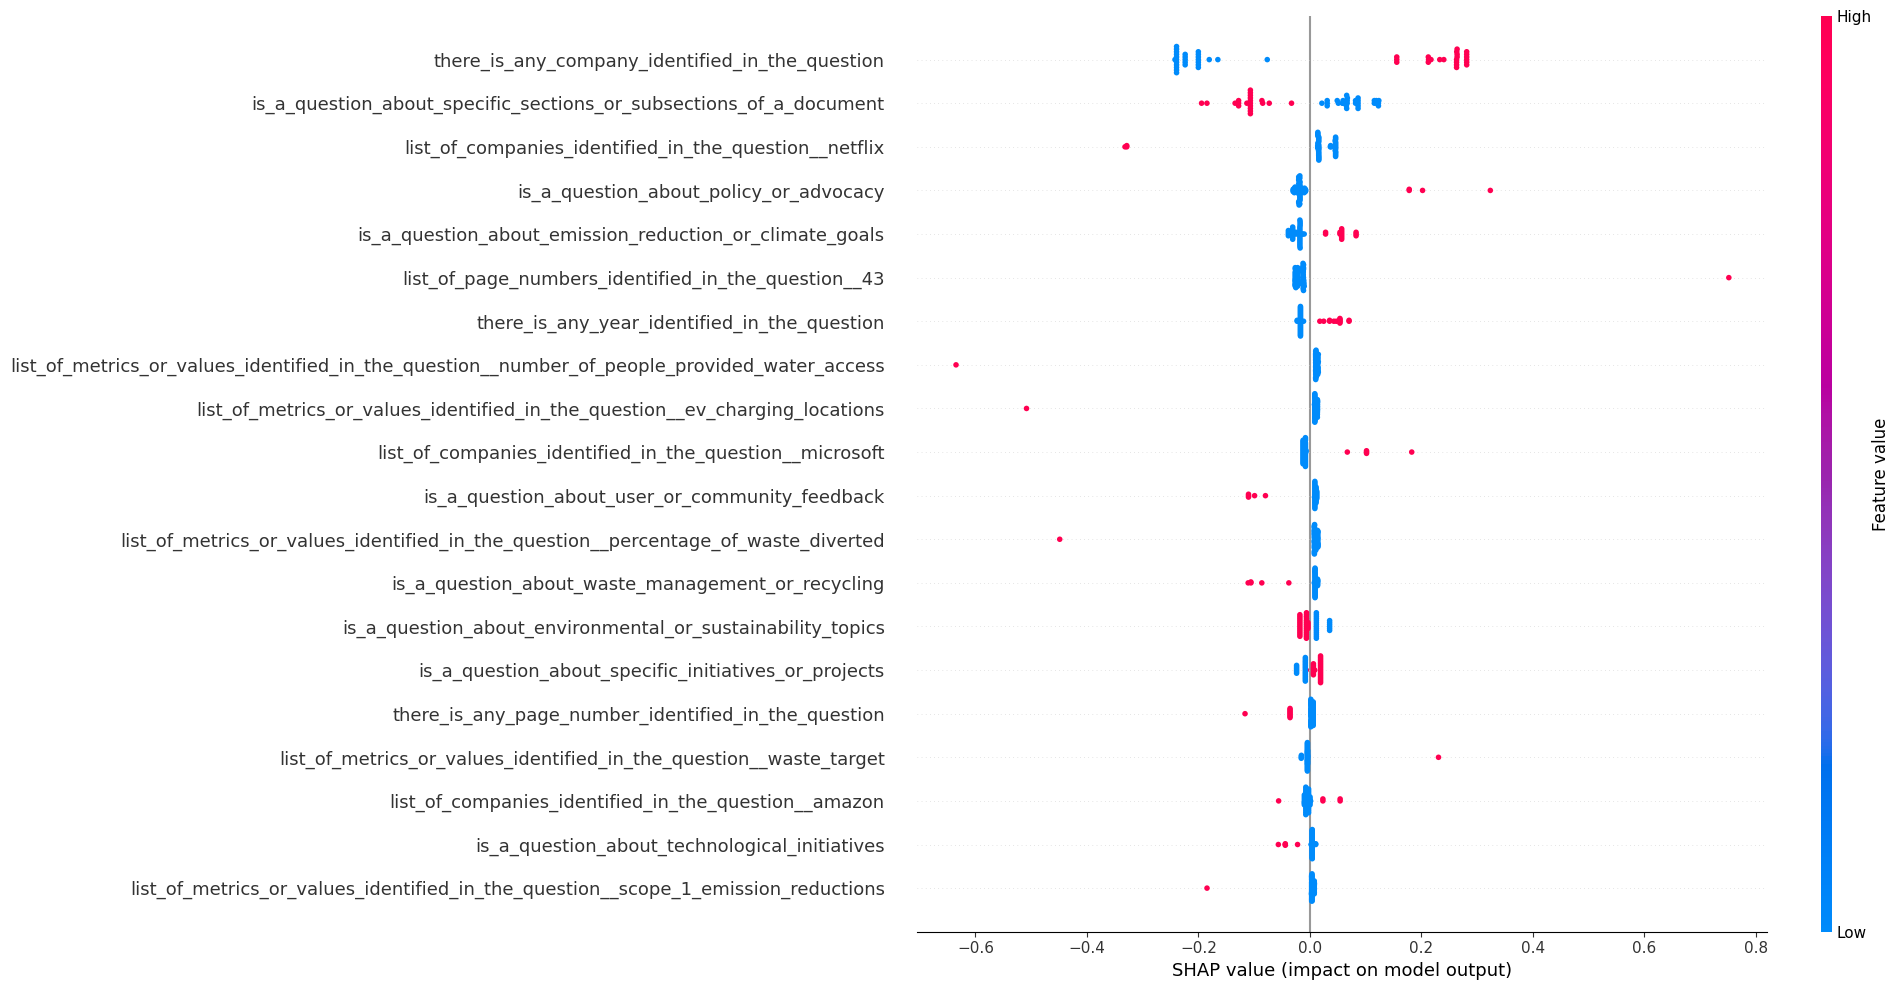

In [21]:
metric_explainer = genai_explainer.explainers_[metric]
shap_values = metric_explainer(X)
shap.summary_plot(shap_values, X, plot_size=(20,10))

### Now let's select one question
1. For the selected question, display the question, the retrieved contexts, the generated and expected answers, the metric value and the predicted metric from the model trained
2. Also, show the SHAP values for the selected question (for the previously selected metric).

> **TO DO:** provide a syntethized explanation of the plot below

Dropdown(description='Select:', index=1, options=(('Can you provide for me the three highlights for the GHG em…


### INDEX 1

**USER INPUT:**
What percentage of waste from Google's offices globally were diverted away from landfills in 2021?

**RETRIEVED CONTEXT:**


**CHUNK 1:**

Performance highlights
The following section provides a snapshot of our performance as of the end 
of 2021—demonstrating how we’re strengthening our business by reducing 
the environmental impact of our operations and working to empower people 
everywhere to live more sustainably. 
For a more complete overview of our performance over time, see the 
environmental data table.
DESIGNING EFFICIENT DATA CENTERS
Energy GHG	emissions
2X  
as	energy	efficient
On average, a Google data center  
is twice as energy efficient as a 
typical enterprise data center. 1 
5X  
as	much	computing	power
Compared with five years ago,  
we now deliver around five times 
as much computing power with the 
same amount of electrical power.
1.10  
average	annual	PUE
In 2021, the average annual PUE 2  
for our global fleet of data centers 
was 1.10, compared with the industry 
average of 1.57 3—meaning that 
Google data centers use about  
six times less overhead energy.
0  
operational	GHG	emissions	
after	compensations
Whether someone is using Google 
at home or as part of an organization 
running Google Cloud or Google 
Workspace, all products in our Cloud 
are carbon neutral—meaning that 
the operational GHG emissions 
associated with running workloads  
on our infrastructure have been 
reduced through procurement of 
renewable energy and any residual 
emissions have been compensated  
for with high-quality carbon credits. 4 
Waste
78%  
of	waste	diverted
In 2021, we diverted 78% of waste 
from our global data center 
operations away from landfills.
27%  
of	components	refurbished
In 2021, 27% of components  
used for server upgrades were 
refurbished inventory.
4.9	million	 
components	resold
In 2021, we resold more than 
4.9 million components into the 
secondary market for reuse by  
other organizations. 
5
Google Environmental Report 2022

**CHUNK 2:**

DESIGNING EFFICIENT DATA CENTERS 
Target Deadline 2021	progress Status
Energy
Maintain or improve average annual fleet-wide  
PUE across Google data centers year over year.
2021 
(Annual)
In 2021, the average annual PUE for our global fleet  
of data centers was 1.10. Since 2012, our average annual  
fleet-wide PUE has stayed at or below 1.12, even as 
demand for our products has dramatically risen.
Certifications
Maintain ISO 50001 energy management system 
certification for Google-owned data centers  
that meet certain operational milestones.
2021 
(Annual)
In 2021, we maintained our ISO 50001 certification for  
our operational European data centers. We were the  
first major internet company to achieve a multi-site  
energy management system certification to ISO 50001, 
which we first attained in 2013.
Waste
Achieve Zero Waste to Landfill for our global  
data center operations.
Not 
applicable
In 2021, our global landfill diversion rate for data center 
operations was 78%.
Water
Replenish 120% of the water we consume,  
on average, across our offices and data centers,  
and help restore and improve the quality of  
water and health of ecosystems in the  
communities where we operate.
2030 We’re working toward this target. By the end  
of 2021, we had supported 13 water stewardship 
projects spanning 10 river basins where we operate 
and/or source water. Examples of these projects 
include wetland restoration, rainwater harvesting,  
and land conservation.
Progress against targets
As a data-driven company, we believe it is critical to regularly track progress 
toward our commitments and share updates with our stakeholders. The 
following section provides an overview of our 2021 progress toward our 
various environmental targets. 
For a more complete overview of our performance over time, see the 
environmental data table.
Achieved Missed In progress
8
Google Environmental Report 2022

**RESPONSE:**
In 2021, 78% of waste from Google's global data center operations was diverted away from landfills. The context does not provide specific information about waste diversion from Google's offices globally.

**REFERENCE:**
Sixty-four percent.

**METRIC → context_precision :** Measures how much of the generated output is relevant and aligns with the context provided in the input.

**METRIC Value:** 0.000

**MODEL ESTIMATED Value:** 0.060


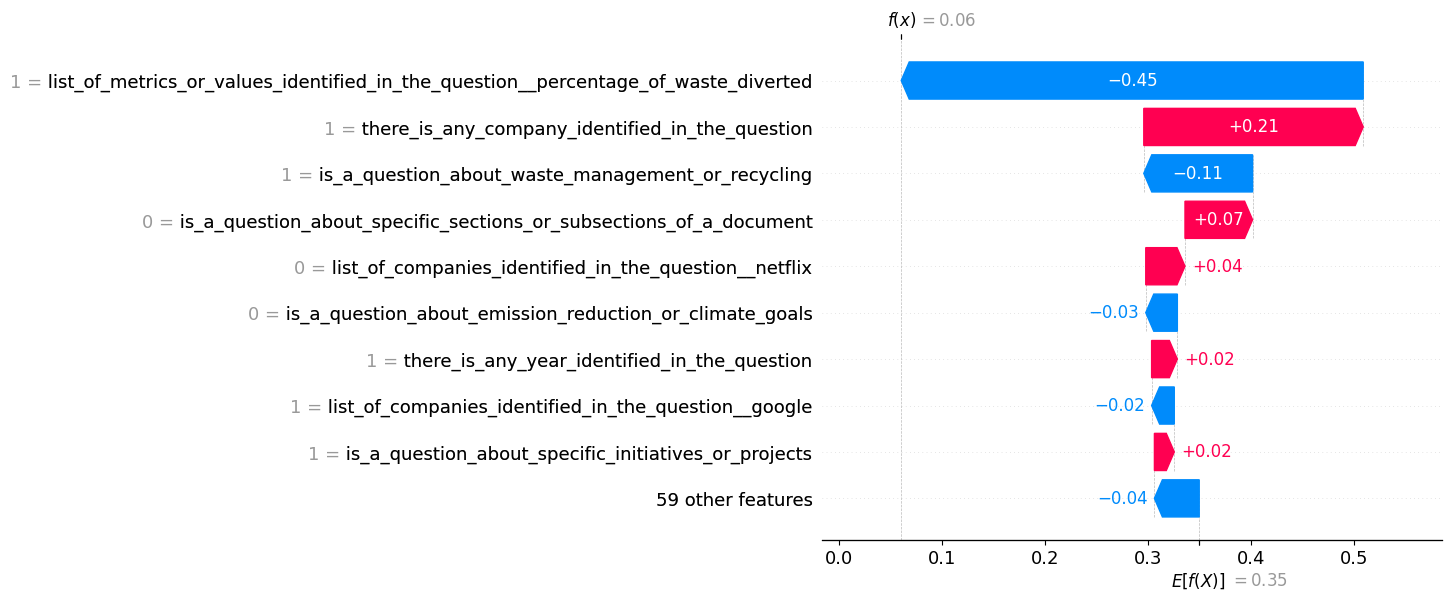

In [22]:
# Define the dropdown values
dropdown_values = df_test_dataset.iloc[:, 0].tolist()

# Create a dropdown widget
dropdown = widgets.Dropdown(
    options=[(value, index) for index, value in enumerate(dropdown_values)],
    description='Select:',
    disabled=False,
)

# Function to handle the dropdown selection
def on_change(change):
    global sel_question
    sel_question = change['new']
    # print(f'Selected question: {sel_question}')

    # Clear the previous output
    clear_output(wait=True)
    
    # Display the dropdown widget again
    display(dropdown)

    # Display the details of the selected question
    index = sel_question

    context = df_test_dataset.loc[index,'retrieved_contexts']
    context_str = "\n".join([f"\n**CHUNK {i+1}:**\n\n{c}" for i, c in zip(range(len(context)),context)])

    index_details = f"""
### INDEX {index}

**USER INPUT:**
{df_test_dataset.loc[index,'user_input']}

**RETRIEVED CONTEXT:**

{context_str}

**RESPONSE:**
{df_test_dataset.loc[index,'response']}

**REFERENCE:**
{df_test_dataset.loc[index,'reference']}

**METRIC → {metric} :** {metric_text}

**METRIC Value:** {df_test_dataset.loc[index, metric]:.3f}

**MODEL ESTIMATED Value:** {df_metric.loc[index, 'estimated_value']:.3f}
"""

    display(Markdown(index_details))
    shap.waterfall_plot(shap_values[index])

# Attach the function to the dropdown widget
dropdown.observe(on_change, names='value')

# Display the dropdown widget
display(dropdown)